In [1]:
import os
import random
import numpy as np
import tensorflow as tf

SEED=42
os.environ["PYTHONHASHSEED"]=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# GPU 설정
gpus=tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2025-06-15 21:45:54.167206: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-15 21:45:54.511565: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-15 21:45:54.511621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-15 21:45:54.526567: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-15 21:45:54.635405: I tensorflow/core/platform/cpu_feature_guar

In [3]:
X=np.load("../../data/processed/03_AIHUB_dataset/X_eye.npy")
Y=np.load("../../data/processed/03_AIHUB_dataset/y_eye.npy")

print(f"X: {X.shape} / Y: {Y.shape}")
print("Class 분포:", np.unique(Y, return_counts=True))

X: (164762, 40, 80, 1) / Y: (164762,)
Class 분포: (array([0, 1]), array([69549, 95213]))


- open이 95213, closed가 69549으로 조금 불균형
- class_wieght 사용해서 불균형 대응예정  

In [5]:
from sklearn.model_selection import train_test_split

X=X/255.0
X_train, X_val, Y_train, Y_val=train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=SEED)

print(f"X_train: {X_train.shape}\nX_val: {X_val.shape}")
print("Y_train 분포:", np.unique(Y_train, return_counts=True))
print("Y_val 분포:", np.unique(Y_val, return_counts=True))

X_train: (131809, 40, 80, 1)
X_val: (32953, 40, 80, 1)
Y_train 분포: (array([0, 1]), array([55639, 76170]))
Y_val 분포: (array([0, 1]), array([13910, 19043]))


In [6]:
from sklearn.utils.class_weight import compute_class_weight

class_weights=compute_class_weight(class_weight="balanced", classes=np.unique(Y_train), y=Y_train)
class_weights=dict(enumerate(class_weights))
print(f"class_weights: {class_weights}")

class_weights: {0: 1.1845018781789751, 1: 0.865229092818695}


# 모델 정의 및 학습  

In [7]:
import tensorflow as tf
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

IMG_SIZE=(40, 80, 1)

model = Sequential([
    Conv2D(64, 3, activation="relu", input_shape=IMG_SIZE),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(96, 3, activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2),

    Flatten(),
    Dense(32, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss="binary_crossentropy", metrics=["accuracy"])

2025-06-15 21:48:38.184307: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-15 21:48:38.184547: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-15 21:48:38.184604: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-15 21:48:38.415678: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-15 21:48:38.415736: I external/local_xla/xla/stream_executor

In [9]:
history=model.fit(X_train, Y_train, epochs=20, batch_size=64, verbose=1,
                  validation_data=(X_val, Y_val), class_weight=class_weights)  # 불균형 대응

Epoch 1/20


2025-06-15 21:50:08.777426: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-06-15 21:50:09.054750: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-06-15 21:50:09.054794: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2025-06-15 21:50:09.055154: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-06-15 21:50:10.482847: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-06-15 21:50:10.621730: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kerne

2060/2060 [==============================] - 31s 12ms/step - loss: 0.5404 - accuracy: 0.7711 - val_loss: 2.6701 - val_accuracy: 0.4813
Epoch 2/20
2060/2060 [==============================] - 23s 11ms/step - loss: 0.4864 - accuracy: 0.8058 - val_loss: 1.5326 - val_accuracy: 0.5796
Epoch 3/20
2060/2060 [==============================] - 24s 11ms/step - loss: 0.4692 - accuracy: 0.8166 - val_loss: 0.7220 - val_accuracy: 0.5779
Epoch 4/20
2060/2060 [==============================] - 23s 11ms/step - loss: 0.4593 - accuracy: 0.8206 - val_loss: 1.0080 - val_accuracy: 0.5000
Epoch 5/20
2060/2060 [==============================] - 23s 11ms/step - loss: 0.4550 - accuracy: 0.8248 - val_loss: 0.7208 - val_accuracy: 0.5791
Epoch 6/20
2060/2060 [==============================] - 23s 11ms/step - loss: 0.4505 - accuracy: 0.8267 - val_loss: 0.8414 - val_accuracy: 0.5790
Epoch 7/20
2060/2060 [==============================] - 23s 11ms/step - loss: 0.4489 - accuracy: 0.8266 - val_loss: 1.6177 - val_accura

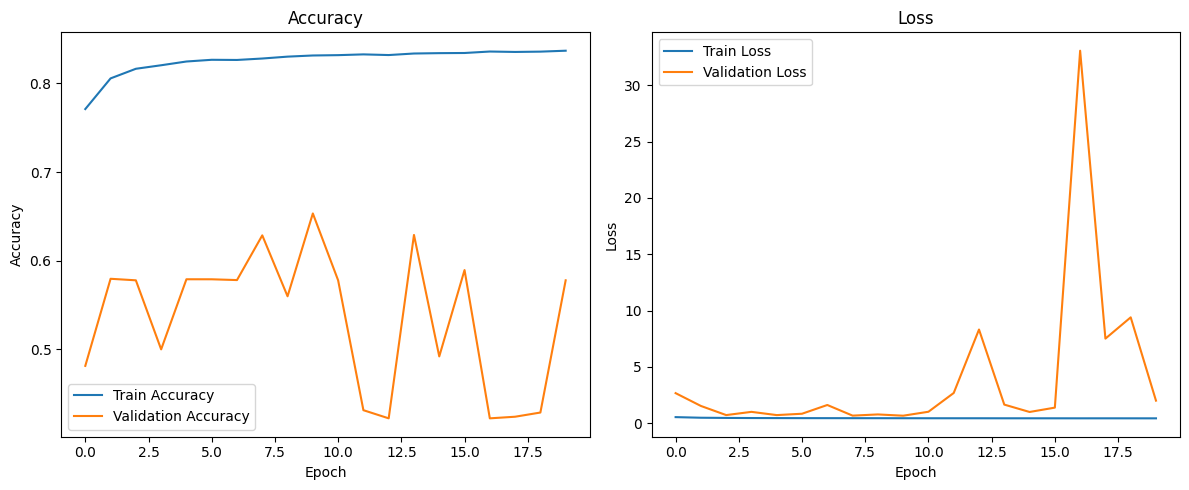

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
# os.makedirs("../../results/images", exist_ok=True)
# plt.savefig("../../results/images/03_final_training_plot.png")
plt.show()

우선 05번 파일과 같은 구조로 진행했을때 너무 떨어지는 결과가 나옴  
다음 개선 방향:  
  - CNN 구조 개선  
  - ResNet50V2 사용  